In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


In [2]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, directory, data_type = None, transform = None, target_transform = None):
        self.data_type = data_type        
        self.directory = directory
        self.transform = transform
        self.target_transform = target_transform
        self.data = None
        self.labels = None
        
        self.fileloader()
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def fileloader(self):        
        if self.data_type == 'train':
            filestart = 'data_batch'
        if self.data_type == 'test':
            filestart = 'test_batch'
            
        for filename in os.listdir(self.directory):
            if filename.startswith(filestart):
                filepath = os.path.join(self.directory, filename)
                file = self.unpickle(filepath)
                if self.data is None:
                    self.data = file[b'data']
                    self.labels = file[b'labels']
                else:
                    self.data = np.vstack((self.data, file[b'data']))
                    self.labels = np.concatenate((self.labels, file[b'labels']))
                    
    def unpickle(self, file):
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [3]:
directory = '/kaggle/input/cifar10-python/cifar-10-batches-py'

train_dataset = CustomDataset(directory, data_type = 'train')
test_dataset = CustomDataset(directory, data_type = 'test')

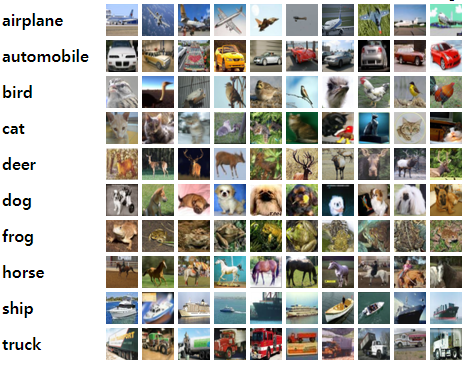

9


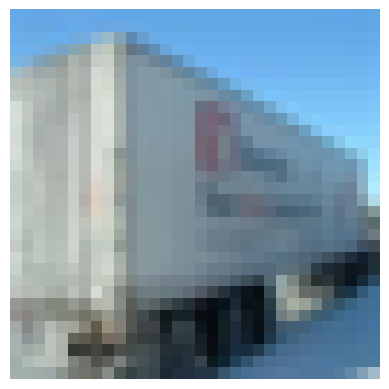

In [4]:
import matplotlib.pyplot as plt

print(train_dataset[15][1])
array = train_dataset[15][0]
reshaped_array = array.reshape((3, 32, 32))
transposed_array = np.transpose(reshaped_array, (1,2,0))

plt.imshow(transposed_array)
plt.axis('off')
plt.show()

In [5]:
from tqdm import tqdm
import time

class NearestNeighborClassifier():
    def __init__(self):
        pass
    
    def train(self, X, Y):
        # X : Ntr x D. Y : Ntr x 1
        self.Xtr = X
        self.Ytr = Y
        
    def predict(self, X, k = None):
        # X : Nte x D
        num_test = X.shape[0]
        Ypred = np.zeros(num_test, dtype = self.Ytr.dtype)
        
        for i in tqdm(range(num_test)):
            distances = np.sum(self.Xtr - X[i,:], axis = 1)
            
            distance_min_k_idx = np.argpartition(distances, k)[:k]
            predict_min_k = self.Ytr[distance_min_k_idx]
            unique_value, count = np.unique(predict_min_k, return_counts = True)
            most_common_prediction = unique_value[np.argmax(count)]
            
            Ypred[i] = most_common_prediction
            
        return Ypred
    
    def nearestimage(self, X):
        # X : 1 x D
        distances = np.sum(self.Xtr - X, axis = 1)
        
        min_index = np.argmin(distances)
        Xpred = self.Xtr[min_index]
        
        reshaped_X = X.reshape((3, 32, 32))
        transposed_X = np.transpose(reshaped_X, (1,2,0))
        
        reshaped_Xpred = Xpred.reshape((3, 32, 32))
        transposed_Xpred = np.transpose(reshaped_Xpred, (1,2,0))
        
        concatenated_X = np.concatenate((transposed_X, transposed_Xpred), axis = 1)

        plt.imshow(concatenated_X)
        plt.axis('off')
        plt.show()

In [6]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [49000, 1000])

In [7]:
validation_accuracies = []
for k in [1,3,5,10,20,50,100]:
    print(f"k : {k}")
    nn = NearestNeighborClassifier()
    nn.train(train_set[:][0], train_set[:][1])
    Yval_predict = nn.predict(val_set[:][0], k = k)
    acc = np.mean(Yval_predict == val_set[:][1])
    print('accuracy : %f' % (acc))
    
    validation_accuracies.append((k, acc))

k : 1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<02:43,  6.11it/s]

  0%|          | 2/1000 [00:00<02:37,  6.35it/s]

  0%|          | 3/1000 [00:00<02:35,  6.43it/s]

  0%|          | 4/1000 [00:00<02:35,  6.41it/s]

  0%|          | 5/1000 [00:00<02:35,  6.42it/s]

  1%|          | 6/1000 [00:00<02:34,  6.44it/s]

  1%|          | 7/1000 [00:01<02:33,  6.45it/s]

  1%|          | 8/1000 [00:01<02:34,  6.44it/s]

  1%|          | 9/1000 [00:01<02:34,  6.42it/s]

  1%|          | 10/1000 [00:01<02:34,  6.39it/s]

  1%|          | 11/1000 [00:01<02:34,  6.40it/s]

  1%|          | 12/1000 [00:01<02:35,  6.36it/s]

  1%|▏         | 13/1000 [00:02<02:34,  6.38it/s]

  1%|▏         | 14/1000 [00:02<02:34,  6.39it/s]

  2%|▏         | 15/1000 [00:02<02:33,  6.41it/s]

  2%|▏         | 16/1000 [00:02<02:33,  6.40it/s]

  2%|▏         | 17/1000 [00:02<02:33,  6.42it/s]

  2%|▏         | 18/1000 [00:02<02:33,  6.40it/s]

  2%|▏         | 19/1000 [00:02<02:33,  6.41it/s]

  2%|▏         | 20/1000 [00:03<02:32,  6.45it/s]

  2%|▏         | 21/1000 [00:03<02:31,  6.45it/s]

  2%|▏         | 22/1000 [00:03<02:32,  6.42it/s]

  2%|▏         | 23/1000 [00:03<02:31,  6.44it/s]

  2%|▏         | 24/1000 [00:03<02:31,  6.46it/s]

  2%|▎         | 25/1000 [00:03<02:31,  6.44it/s]

  3%|▎         | 26/1000 [00:04<02:30,  6.46it/s]

  3%|▎         | 27/1000 [00:04<02:30,  6.47it/s]

  3%|▎         | 28/1000 [00:04<02:30,  6.47it/s]

  3%|▎         | 29/1000 [00:04<02:29,  6.49it/s]

  3%|▎         | 30/1000 [00:04<02:29,  6.49it/s]

  3%|▎         | 31/1000 [00:04<02:29,  6.48it/s]

  3%|▎         | 32/1000 [00:04<02:29,  6.47it/s]

  3%|▎         | 33/1000 [00:05<02:28,  6.49it/s]

  3%|▎         | 34/1000 [00:05<02:28,  6.49it/s]

  4%|▎         | 35/1000 [00:05<02:29,  6.45it/s]

  4%|▎         | 36/1000 [00:05<02:29,  6.43it/s]

  4%|▎         | 37/1000 [00:05<02:29,  6.45it/s]

  4%|▍         | 38/1000 [00:05<02:29,  6.42it/s]

  4%|▍         | 39/1000 [00:06<02:29,  6.42it/s]

  4%|▍         | 40/1000 [00:06<02:30,  6.37it/s]

  4%|▍         | 41/1000 [00:06<02:30,  6.37it/s]

  4%|▍         | 42/1000 [00:06<02:29,  6.41it/s]

  4%|▍         | 43/1000 [00:06<02:28,  6.45it/s]

  4%|▍         | 44/1000 [00:06<02:28,  6.45it/s]

  4%|▍         | 45/1000 [00:06<02:27,  6.46it/s]

  5%|▍         | 46/1000 [00:07<02:27,  6.46it/s]

  5%|▍         | 47/1000 [00:07<02:27,  6.45it/s]

  5%|▍         | 48/1000 [00:07<02:27,  6.47it/s]

  5%|▍         | 49/1000 [00:07<02:27,  6.45it/s]

  5%|▌         | 50/1000 [00:07<02:28,  6.39it/s]

  5%|▌         | 51/1000 [00:07<02:31,  6.28it/s]

  5%|▌         | 52/1000 [00:08<02:33,  6.19it/s]

  5%|▌         | 53/1000 [00:08<02:31,  6.25it/s]

  5%|▌         | 54/1000 [00:08<02:30,  6.30it/s]

  6%|▌         | 55/1000 [00:08<02:29,  6.34it/s]

  6%|▌         | 56/1000 [00:08<02:28,  6.37it/s]

  6%|▌         | 57/1000 [00:08<02:27,  6.40it/s]

  6%|▌         | 58/1000 [00:09<02:26,  6.42it/s]

  6%|▌         | 59/1000 [00:09<02:26,  6.43it/s]

  6%|▌         | 60/1000 [00:09<02:26,  6.44it/s]

  6%|▌         | 61/1000 [00:09<02:25,  6.44it/s]

  6%|▌         | 62/1000 [00:09<02:25,  6.43it/s]

  6%|▋         | 63/1000 [00:09<02:25,  6.42it/s]

  6%|▋         | 64/1000 [00:09<02:26,  6.38it/s]

  6%|▋         | 65/1000 [00:10<02:26,  6.37it/s]

  7%|▋         | 66/1000 [00:10<02:28,  6.30it/s]

  7%|▋         | 67/1000 [00:10<02:28,  6.30it/s]

  7%|▋         | 68/1000 [00:10<02:27,  6.31it/s]

  7%|▋         | 69/1000 [00:10<02:27,  6.32it/s]

  7%|▋         | 70/1000 [00:10<02:26,  6.35it/s]

  7%|▋         | 71/1000 [00:11<02:25,  6.40it/s]

  7%|▋         | 72/1000 [00:11<02:25,  6.37it/s]

  7%|▋         | 73/1000 [00:11<02:26,  6.33it/s]

  7%|▋         | 74/1000 [00:11<02:26,  6.30it/s]

  8%|▊         | 75/1000 [00:11<02:25,  6.35it/s]

  8%|▊         | 76/1000 [00:11<02:25,  6.34it/s]

  8%|▊         | 77/1000 [00:12<02:25,  6.35it/s]

  8%|▊         | 78/1000 [00:12<02:24,  6.37it/s]

  8%|▊         | 79/1000 [00:12<02:23,  6.42it/s]

  8%|▊         | 80/1000 [00:12<02:22,  6.47it/s]

  8%|▊         | 81/1000 [00:12<02:21,  6.49it/s]

  8%|▊         | 82/1000 [00:12<02:22,  6.46it/s]

  8%|▊         | 83/1000 [00:12<02:22,  6.44it/s]

  8%|▊         | 84/1000 [00:13<02:22,  6.44it/s]

  8%|▊         | 85/1000 [00:13<02:22,  6.42it/s]

  9%|▊         | 86/1000 [00:13<02:21,  6.45it/s]

  9%|▊         | 87/1000 [00:13<02:21,  6.46it/s]

  9%|▉         | 88/1000 [00:13<02:21,  6.44it/s]

  9%|▉         | 89/1000 [00:13<02:21,  6.43it/s]

  9%|▉         | 90/1000 [00:14<02:21,  6.44it/s]

  9%|▉         | 91/1000 [00:14<02:20,  6.45it/s]

  9%|▉         | 92/1000 [00:14<02:21,  6.41it/s]

  9%|▉         | 93/1000 [00:14<02:21,  6.40it/s]

  9%|▉         | 94/1000 [00:14<02:20,  6.43it/s]

 10%|▉         | 95/1000 [00:14<02:20,  6.42it/s]

 10%|▉         | 96/1000 [00:14<02:21,  6.39it/s]

 10%|▉         | 97/1000 [00:15<02:21,  6.40it/s]

 10%|▉         | 98/1000 [00:15<02:21,  6.35it/s]

 10%|▉         | 99/1000 [00:15<02:21,  6.35it/s]

 10%|█         | 100/1000 [00:15<02:22,  6.34it/s]

 10%|█         | 101/1000 [00:15<02:21,  6.33it/s]

 10%|█         | 102/1000 [00:15<02:21,  6.33it/s]

 10%|█         | 103/1000 [00:16<02:21,  6.33it/s]

 10%|█         | 104/1000 [00:16<02:21,  6.32it/s]

 10%|█         | 105/1000 [00:16<02:20,  6.39it/s]

 11%|█         | 106/1000 [00:16<02:19,  6.42it/s]

 11%|█         | 107/1000 [00:16<02:18,  6.44it/s]

 11%|█         | 108/1000 [00:16<02:18,  6.43it/s]

 11%|█         | 109/1000 [00:17<02:18,  6.42it/s]

 11%|█         | 110/1000 [00:17<02:19,  6.40it/s]

 11%|█         | 111/1000 [00:17<02:18,  6.42it/s]

 11%|█         | 112/1000 [00:17<02:19,  6.39it/s]

 11%|█▏        | 113/1000 [00:17<02:21,  6.27it/s]

 11%|█▏        | 114/1000 [00:17<02:27,  6.00it/s]

 12%|█▏        | 115/1000 [00:18<02:36,  5.66it/s]

 12%|█▏        | 116/1000 [00:18<02:36,  5.64it/s]

 12%|█▏        | 117/1000 [00:18<02:31,  5.83it/s]

 12%|█▏        | 118/1000 [00:18<02:32,  5.80it/s]

 12%|█▏        | 119/1000 [00:18<02:27,  5.97it/s]

 12%|█▏        | 120/1000 [00:18<02:26,  6.03it/s]

 12%|█▏        | 121/1000 [00:19<02:23,  6.12it/s]

 12%|█▏        | 122/1000 [00:19<02:22,  6.18it/s]

 12%|█▏        | 123/1000 [00:19<02:20,  6.25it/s]

 12%|█▏        | 124/1000 [00:19<02:19,  6.29it/s]

 12%|█▎        | 125/1000 [00:19<02:18,  6.32it/s]

 13%|█▎        | 126/1000 [00:19<02:18,  6.32it/s]

 13%|█▎        | 127/1000 [00:19<02:18,  6.30it/s]

 13%|█▎        | 128/1000 [00:20<02:20,  6.21it/s]

 13%|█▎        | 129/1000 [00:20<02:21,  6.17it/s]

 13%|█▎        | 130/1000 [00:20<02:20,  6.20it/s]

 13%|█▎        | 131/1000 [00:20<02:20,  6.21it/s]

 13%|█▎        | 132/1000 [00:20<02:19,  6.22it/s]

 13%|█▎        | 133/1000 [00:20<02:19,  6.22it/s]

 13%|█▎        | 134/1000 [00:21<02:17,  6.28it/s]

 14%|█▎        | 135/1000 [00:21<02:18,  6.25it/s]

 14%|█▎        | 136/1000 [00:21<02:18,  6.23it/s]

 14%|█▎        | 137/1000 [00:21<02:18,  6.21it/s]

 14%|█▍        | 138/1000 [00:21<02:18,  6.23it/s]

 14%|█▍        | 139/1000 [00:21<02:17,  6.26it/s]

 14%|█▍        | 140/1000 [00:22<02:16,  6.32it/s]

 14%|█▍        | 141/1000 [00:22<02:15,  6.33it/s]

 14%|█▍        | 142/1000 [00:22<02:14,  6.36it/s]

 14%|█▍        | 143/1000 [00:22<02:15,  6.34it/s]

 14%|█▍        | 144/1000 [00:22<02:15,  6.32it/s]

 14%|█▍        | 145/1000 [00:22<02:15,  6.32it/s]

 15%|█▍        | 146/1000 [00:23<02:15,  6.31it/s]

 15%|█▍        | 147/1000 [00:23<02:14,  6.34it/s]

 15%|█▍        | 148/1000 [00:23<02:13,  6.36it/s]

 15%|█▍        | 149/1000 [00:23<02:13,  6.38it/s]

 15%|█▌        | 150/1000 [00:23<02:12,  6.40it/s]

 15%|█▌        | 151/1000 [00:23<02:12,  6.41it/s]

 15%|█▌        | 152/1000 [00:23<02:12,  6.41it/s]

 15%|█▌        | 153/1000 [00:24<02:11,  6.42it/s]

 15%|█▌        | 154/1000 [00:24<02:11,  6.43it/s]

 16%|█▌        | 155/1000 [00:24<02:11,  6.41it/s]

 16%|█▌        | 156/1000 [00:24<02:12,  6.38it/s]

 16%|█▌        | 157/1000 [00:24<02:11,  6.39it/s]

 16%|█▌        | 158/1000 [00:24<02:12,  6.35it/s]

 16%|█▌        | 159/1000 [00:25<02:12,  6.35it/s]

 16%|█▌        | 160/1000 [00:25<02:12,  6.35it/s]

 16%|█▌        | 161/1000 [00:25<02:11,  6.37it/s]

 16%|█▌        | 162/1000 [00:25<02:12,  6.33it/s]

 16%|█▋        | 163/1000 [00:25<02:11,  6.35it/s]

 16%|█▋        | 164/1000 [00:25<02:11,  6.35it/s]

 16%|█▋        | 165/1000 [00:25<02:12,  6.30it/s]

 17%|█▋        | 166/1000 [00:26<02:14,  6.20it/s]

 17%|█▋        | 167/1000 [00:26<02:14,  6.20it/s]

 17%|█▋        | 168/1000 [00:26<02:12,  6.26it/s]

 17%|█▋        | 169/1000 [00:26<02:11,  6.31it/s]

 17%|█▋        | 170/1000 [00:26<02:11,  6.29it/s]

 17%|█▋        | 171/1000 [00:26<02:11,  6.31it/s]

 17%|█▋        | 172/1000 [00:27<02:10,  6.35it/s]

 17%|█▋        | 173/1000 [00:27<02:10,  6.34it/s]

 17%|█▋        | 174/1000 [00:27<02:09,  6.36it/s]

 18%|█▊        | 175/1000 [00:27<02:09,  6.37it/s]

 18%|█▊        | 176/1000 [00:27<02:09,  6.35it/s]

 18%|█▊        | 177/1000 [00:27<02:10,  6.32it/s]

 18%|█▊        | 178/1000 [00:28<02:12,  6.18it/s]

 18%|█▊        | 179/1000 [00:28<02:11,  6.24it/s]

 18%|█▊        | 180/1000 [00:28<02:10,  6.27it/s]

 18%|█▊        | 181/1000 [00:28<02:10,  6.30it/s]

 18%|█▊        | 182/1000 [00:28<02:08,  6.34it/s]

 18%|█▊        | 183/1000 [00:28<02:08,  6.38it/s]

 18%|█▊        | 184/1000 [00:28<02:07,  6.40it/s]

 18%|█▊        | 185/1000 [00:29<02:07,  6.41it/s]

 19%|█▊        | 186/1000 [00:29<02:07,  6.39it/s]

 19%|█▊        | 187/1000 [00:29<02:07,  6.40it/s]

 19%|█▉        | 188/1000 [00:29<02:06,  6.41it/s]

 19%|█▉        | 189/1000 [00:29<02:07,  6.36it/s]

 19%|█▉        | 190/1000 [00:29<02:07,  6.34it/s]

 19%|█▉        | 191/1000 [00:30<02:08,  6.29it/s]

 19%|█▉        | 192/1000 [00:30<02:07,  6.34it/s]

 19%|█▉        | 193/1000 [00:30<02:07,  6.35it/s]

 19%|█▉        | 194/1000 [00:30<02:08,  6.26it/s]

 20%|█▉        | 195/1000 [00:30<02:08,  6.28it/s]

 20%|█▉        | 196/1000 [00:30<02:07,  6.32it/s]

 20%|█▉        | 197/1000 [00:31<02:07,  6.32it/s]

 20%|█▉        | 198/1000 [00:31<02:06,  6.35it/s]

 20%|█▉        | 199/1000 [00:31<02:05,  6.37it/s]

 20%|██        | 200/1000 [00:31<02:05,  6.39it/s]

 20%|██        | 201/1000 [00:31<02:04,  6.40it/s]

 20%|██        | 202/1000 [00:31<02:04,  6.39it/s]

 20%|██        | 203/1000 [00:31<02:04,  6.38it/s]

 20%|██        | 204/1000 [00:32<02:03,  6.42it/s]

 20%|██        | 205/1000 [00:32<02:03,  6.41it/s]

 21%|██        | 206/1000 [00:32<02:03,  6.42it/s]

 21%|██        | 207/1000 [00:32<02:03,  6.40it/s]

 21%|██        | 208/1000 [00:32<02:03,  6.42it/s]

 21%|██        | 209/1000 [00:32<02:03,  6.38it/s]

 21%|██        | 210/1000 [00:33<02:03,  6.40it/s]

 21%|██        | 211/1000 [00:33<02:03,  6.38it/s]

 21%|██        | 212/1000 [00:33<02:04,  6.35it/s]

 21%|██▏       | 213/1000 [00:33<02:04,  6.34it/s]

 21%|██▏       | 214/1000 [00:33<02:04,  6.33it/s]

 22%|██▏       | 215/1000 [00:33<02:03,  6.34it/s]

 22%|██▏       | 216/1000 [00:34<02:03,  6.35it/s]

 22%|██▏       | 217/1000 [00:34<02:03,  6.34it/s]

 22%|██▏       | 218/1000 [00:34<02:04,  6.28it/s]

 22%|██▏       | 219/1000 [00:34<02:03,  6.31it/s]

 22%|██▏       | 220/1000 [00:34<02:03,  6.34it/s]

 22%|██▏       | 221/1000 [00:34<02:03,  6.31it/s]

 22%|██▏       | 222/1000 [00:34<02:03,  6.30it/s]

 22%|██▏       | 223/1000 [00:35<02:03,  6.30it/s]

 22%|██▏       | 224/1000 [00:35<02:02,  6.32it/s]

 22%|██▎       | 225/1000 [00:35<02:02,  6.34it/s]

 23%|██▎       | 226/1000 [00:35<02:02,  6.29it/s]

 23%|██▎       | 227/1000 [00:35<02:02,  6.31it/s]

 23%|██▎       | 228/1000 [00:35<02:02,  6.28it/s]

 23%|██▎       | 229/1000 [00:36<02:02,  6.28it/s]

 23%|██▎       | 230/1000 [00:36<02:03,  6.22it/s]

 23%|██▎       | 231/1000 [00:36<02:04,  6.19it/s]

 23%|██▎       | 232/1000 [00:36<02:03,  6.23it/s]

 23%|██▎       | 233/1000 [00:36<02:02,  6.26it/s]

 23%|██▎       | 234/1000 [00:36<02:02,  6.25it/s]

 24%|██▎       | 235/1000 [00:37<02:01,  6.27it/s]

 24%|██▎       | 236/1000 [00:37<02:00,  6.33it/s]

 24%|██▎       | 237/1000 [00:37<01:59,  6.37it/s]

 24%|██▍       | 238/1000 [00:37<02:01,  6.25it/s]

 24%|██▍       | 239/1000 [00:37<02:05,  6.04it/s]

 24%|██▍       | 240/1000 [00:37<02:09,  5.88it/s]

 24%|██▍       | 241/1000 [00:38<02:12,  5.74it/s]

 24%|██▍       | 242/1000 [00:38<02:09,  5.86it/s]

 24%|██▍       | 243/1000 [00:38<02:08,  5.89it/s]

 24%|██▍       | 244/1000 [00:38<02:07,  5.94it/s]

 24%|██▍       | 245/1000 [00:38<02:04,  6.07it/s]

 25%|██▍       | 246/1000 [00:38<02:02,  6.16it/s]

 25%|██▍       | 247/1000 [00:39<02:01,  6.19it/s]

 25%|██▍       | 248/1000 [00:39<02:00,  6.23it/s]

 25%|██▍       | 249/1000 [00:39<02:00,  6.24it/s]

 25%|██▌       | 250/1000 [00:39<01:59,  6.26it/s]

 25%|██▌       | 251/1000 [00:39<01:59,  6.29it/s]

 25%|██▌       | 252/1000 [00:39<01:58,  6.29it/s]

 25%|██▌       | 253/1000 [00:39<01:59,  6.26it/s]

 25%|██▌       | 254/1000 [00:40<02:00,  6.17it/s]

 26%|██▌       | 255/1000 [00:40<02:04,  6.00it/s]

 26%|██▌       | 256/1000 [00:40<02:03,  6.02it/s]

 26%|██▌       | 257/1000 [00:40<02:01,  6.10it/s]

 26%|██▌       | 258/1000 [00:40<02:01,  6.12it/s]

 26%|██▌       | 259/1000 [00:40<02:00,  6.16it/s]

 26%|██▌       | 260/1000 [00:41<01:58,  6.22it/s]

 26%|██▌       | 261/1000 [00:41<01:58,  6.22it/s]

 26%|██▌       | 262/1000 [00:41<01:58,  6.24it/s]

 26%|██▋       | 263/1000 [00:41<01:58,  6.23it/s]

 26%|██▋       | 264/1000 [00:41<01:57,  6.26it/s]

 26%|██▋       | 265/1000 [00:41<01:57,  6.27it/s]

 27%|██▋       | 266/1000 [00:42<01:56,  6.30it/s]

 27%|██▋       | 267/1000 [00:42<01:55,  6.33it/s]

 27%|██▋       | 268/1000 [00:42<01:55,  6.33it/s]

 27%|██▋       | 269/1000 [00:42<01:55,  6.32it/s]

 27%|██▋       | 270/1000 [00:42<01:55,  6.30it/s]

 27%|██▋       | 271/1000 [00:42<01:56,  6.28it/s]

 27%|██▋       | 272/1000 [00:43<01:56,  6.25it/s]

 27%|██▋       | 273/1000 [00:43<01:56,  6.26it/s]

 27%|██▋       | 274/1000 [00:43<01:55,  6.27it/s]

 28%|██▊       | 275/1000 [00:43<01:55,  6.28it/s]

 28%|██▊       | 276/1000 [00:43<01:55,  6.28it/s]

 28%|██▊       | 277/1000 [00:43<01:55,  6.26it/s]

 28%|██▊       | 278/1000 [00:44<01:55,  6.25it/s]

 28%|██▊       | 279/1000 [00:44<01:55,  6.24it/s]

 28%|██▊       | 280/1000 [00:44<01:55,  6.25it/s]

 28%|██▊       | 281/1000 [00:44<01:54,  6.29it/s]

 28%|██▊       | 282/1000 [00:44<01:53,  6.31it/s]

 28%|██▊       | 283/1000 [00:44<01:54,  6.24it/s]

 28%|██▊       | 284/1000 [00:44<01:54,  6.24it/s]

 28%|██▊       | 285/1000 [00:45<01:53,  6.29it/s]

 29%|██▊       | 286/1000 [00:45<01:53,  6.32it/s]

 29%|██▊       | 287/1000 [00:45<01:52,  6.34it/s]

 29%|██▉       | 288/1000 [00:45<01:52,  6.34it/s]

 29%|██▉       | 289/1000 [00:45<01:51,  6.38it/s]

 29%|██▉       | 290/1000 [00:45<01:51,  6.39it/s]

 29%|██▉       | 291/1000 [00:46<01:51,  6.33it/s]

 29%|██▉       | 292/1000 [00:46<01:52,  6.29it/s]

 29%|██▉       | 293/1000 [00:46<01:52,  6.31it/s]

 29%|██▉       | 294/1000 [00:46<01:51,  6.32it/s]

 30%|██▉       | 295/1000 [00:46<01:51,  6.33it/s]

 30%|██▉       | 296/1000 [00:46<01:50,  6.35it/s]

 30%|██▉       | 297/1000 [00:47<01:50,  6.38it/s]

 30%|██▉       | 298/1000 [00:47<01:50,  6.33it/s]

 30%|██▉       | 299/1000 [00:47<01:51,  6.27it/s]

 30%|███       | 300/1000 [00:47<01:51,  6.30it/s]

 30%|███       | 301/1000 [00:47<01:51,  6.29it/s]

 30%|███       | 302/1000 [00:47<01:51,  6.27it/s]

 30%|███       | 303/1000 [00:47<01:53,  6.14it/s]

 30%|███       | 304/1000 [00:48<01:53,  6.14it/s]

 30%|███       | 305/1000 [00:48<01:51,  6.21it/s]

 31%|███       | 306/1000 [00:48<01:50,  6.27it/s]

 31%|███       | 307/1000 [00:48<01:49,  6.31it/s]

 31%|███       | 308/1000 [00:48<01:49,  6.33it/s]

 31%|███       | 309/1000 [00:48<01:48,  6.34it/s]

 31%|███       | 310/1000 [00:49<01:48,  6.37it/s]

 31%|███       | 311/1000 [00:49<01:51,  6.16it/s]

 31%|███       | 312/1000 [00:49<01:51,  6.19it/s]

 31%|███▏      | 313/1000 [00:49<01:50,  6.21it/s]

 31%|███▏      | 314/1000 [00:49<01:50,  6.18it/s]

 32%|███▏      | 315/1000 [00:49<01:50,  6.17it/s]

 32%|███▏      | 316/1000 [00:50<01:52,  6.11it/s]

 32%|███▏      | 317/1000 [00:50<01:51,  6.10it/s]

 32%|███▏      | 318/1000 [00:50<01:52,  6.08it/s]

 32%|███▏      | 319/1000 [00:50<01:50,  6.14it/s]

 32%|███▏      | 320/1000 [00:50<01:49,  6.19it/s]

 32%|███▏      | 321/1000 [00:50<01:49,  6.21it/s]

 32%|███▏      | 322/1000 [00:51<01:48,  6.27it/s]

 32%|███▏      | 323/1000 [00:51<01:47,  6.27it/s]

 32%|███▏      | 324/1000 [00:51<01:47,  6.28it/s]

 32%|███▎      | 325/1000 [00:51<01:47,  6.26it/s]

 33%|███▎      | 326/1000 [00:51<01:46,  6.30it/s]

 33%|███▎      | 327/1000 [00:51<01:46,  6.31it/s]

 33%|███▎      | 328/1000 [00:51<01:46,  6.34it/s]

 33%|███▎      | 329/1000 [00:52<01:45,  6.38it/s]

 33%|███▎      | 330/1000 [00:52<01:45,  6.38it/s]

 33%|███▎      | 331/1000 [00:52<01:44,  6.42it/s]

 33%|███▎      | 332/1000 [00:52<01:44,  6.37it/s]

 33%|███▎      | 333/1000 [00:52<01:44,  6.40it/s]

 33%|███▎      | 334/1000 [00:52<01:44,  6.37it/s]

 34%|███▎      | 335/1000 [00:53<01:44,  6.37it/s]

 34%|███▎      | 336/1000 [00:53<01:44,  6.36it/s]

 34%|███▎      | 337/1000 [00:53<01:43,  6.38it/s]

 34%|███▍      | 338/1000 [00:53<01:43,  6.38it/s]

 34%|███▍      | 339/1000 [00:53<01:43,  6.40it/s]

 34%|███▍      | 340/1000 [00:53<01:42,  6.42it/s]

 34%|███▍      | 341/1000 [00:54<01:42,  6.43it/s]

 34%|███▍      | 342/1000 [00:54<01:42,  6.40it/s]

 34%|███▍      | 343/1000 [00:54<01:42,  6.43it/s]

 34%|███▍      | 344/1000 [00:54<01:42,  6.41it/s]

 34%|███▍      | 345/1000 [00:54<01:42,  6.39it/s]

 35%|███▍      | 346/1000 [00:54<01:42,  6.37it/s]

 35%|███▍      | 347/1000 [00:54<01:42,  6.37it/s]

 35%|███▍      | 348/1000 [00:55<01:42,  6.34it/s]

 35%|███▍      | 349/1000 [00:55<01:42,  6.34it/s]

 35%|███▌      | 350/1000 [00:55<01:42,  6.37it/s]

 35%|███▌      | 351/1000 [00:55<01:41,  6.38it/s]

 35%|███▌      | 352/1000 [00:55<01:44,  6.19it/s]

 35%|███▌      | 353/1000 [00:55<01:45,  6.15it/s]

 35%|███▌      | 354/1000 [00:56<01:44,  6.19it/s]

 36%|███▌      | 355/1000 [00:56<01:44,  6.18it/s]

 36%|███▌      | 356/1000 [00:56<01:43,  6.21it/s]

 36%|███▌      | 357/1000 [00:56<01:43,  6.21it/s]

 36%|███▌      | 358/1000 [00:56<01:42,  6.27it/s]

 36%|███▌      | 359/1000 [00:56<01:41,  6.31it/s]

 36%|███▌      | 360/1000 [00:57<01:40,  6.37it/s]

 36%|███▌      | 361/1000 [00:57<01:40,  6.39it/s]

 36%|███▌      | 362/1000 [00:57<01:39,  6.40it/s]

 36%|███▋      | 363/1000 [00:57<01:39,  6.41it/s]

 36%|███▋      | 364/1000 [00:57<01:39,  6.40it/s]

 36%|███▋      | 365/1000 [00:57<01:40,  6.34it/s]

 37%|███▋      | 366/1000 [00:57<01:42,  6.18it/s]

 37%|███▋      | 367/1000 [00:58<01:41,  6.22it/s]

 37%|███▋      | 368/1000 [00:58<01:40,  6.26it/s]

 37%|███▋      | 369/1000 [00:58<01:40,  6.30it/s]

 37%|███▋      | 370/1000 [00:58<01:39,  6.34it/s]

 37%|███▋      | 371/1000 [00:58<01:38,  6.36it/s]

 37%|███▋      | 372/1000 [00:58<01:38,  6.37it/s]

 37%|███▋      | 373/1000 [00:59<01:38,  6.37it/s]

 37%|███▋      | 374/1000 [00:59<01:38,  6.38it/s]

 38%|███▊      | 375/1000 [00:59<01:37,  6.39it/s]

 38%|███▊      | 376/1000 [00:59<01:37,  6.37it/s]

 38%|███▊      | 377/1000 [00:59<01:37,  6.37it/s]

 38%|███▊      | 378/1000 [00:59<01:37,  6.38it/s]

 38%|███▊      | 379/1000 [01:00<01:37,  6.34it/s]

In [ ]:
k = max(validation_accuracies, key = lambda x: x[1])[0]

nn = NearestNeighborClassifier()
nn.train(train_set[:][0], train_set[:][1])
Yte_predict = nn.predict(test_dataset[:][0], k = k)
acc = np.mean(Yte_predict == test_dataset[:][1])
print('accuracy : %f' % (acc))

In [ ]:
nn = NearestNeighborClassifier()
nn.train(train_set[:][0], train_set[:][1])

for i in np.random.randint(0, 10000, size=10):
    nn.nearestimage(test_dataset[i][0])